## Importing the packages

In [138]:
import os
import math
import joblib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
from dython.nominal import associations
from sklearn.ensemble import IsolationForest
from scipy.stats import zscore
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils.class_weight import compute_class_weight

## Reading the data

In [2]:
data_dir = "."

In [3]:
data_files = [file for file in os.listdir(data_dir) if file.endswith('csv')]
print(data_files)

['countries.csv', 'age_gender_bkts.csv', 'train_users_2.csv', 'test_users.csv', 'airbnb_data_raw.csv', 'sessions.csv']


### Train data

In [4]:
train_df = pd.read_csv(os.path.join(data_dir, "train_users_2.csv"), encoding="latin-1")

In [5]:
train_df.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [6]:
train_df.shape

(213451, 16)

In [7]:
train_df.columns

Index(['id', 'date_account_created', 'timestamp_first_active',
       'date_first_booking', 'gender', 'age', 'signup_method', 'signup_flow',
       'language', 'affiliate_channel', 'affiliate_provider',
       'first_affiliate_tracked', 'signup_app', 'first_device_type',
       'first_browser', 'country_destination'],
      dtype='object')

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213451 entries, 0 to 213450
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       213451 non-null  object 
 1   date_account_created     213451 non-null  object 
 2   timestamp_first_active   213451 non-null  int64  
 3   date_first_booking       88908 non-null   object 
 4   gender                   213451 non-null  object 
 5   age                      125461 non-null  float64
 6   signup_method            213451 non-null  object 
 7   signup_flow              213451 non-null  int64  
 8   language                 213451 non-null  object 
 9   affiliate_channel        213451 non-null  object 
 10  affiliate_provider       213451 non-null  object 
 11  first_affiliate_tracked  207386 non-null  object 
 12  signup_app               213451 non-null  object 
 13  first_device_type        213451 non-null  object 
 14  firs

In [9]:
# Handle the date column

train_df['first_booking_year'] = pd.to_datetime(train_df['date_first_booking']).dt.year
train_df['first_booking_month'] = pd.to_datetime(train_df['date_first_booking']).dt.month_name()

train_df.drop('date_first_booking', axis=1, inplace=True)


train_df['account_created_year'] = pd.to_datetime(train_df['date_account_created']).dt.year
train_df['account_created_month'] = pd.to_datetime(train_df['date_account_created']).dt.month_name()

train_df.drop('date_account_created', axis=1, inplace=True)

In [10]:
train_df.head()

,id,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,first_booking_year,first_booking_month,account_created_year,account_created_month
0,gxn3p5htnn,20090319043255,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF,NaN,NaN,2010,June
1,820tgsjxq7,20090523174809,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF,NaN,NaN,2011,May
2,4ft3gnwmtx,20090609231247,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US,2010.0,August,2010,September
3,bjjt8pjhuk,20091031060129,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other,2012.0,September,2011,December
4,87mebub9p4,20091208061105,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US,2010.0,February,2010,September


### Test data

In [11]:
test_df = pd.read_csv(os.path.join(data_dir, "test_users.csv"), encoding="latin-1")

In [12]:
test_df.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
0,5uwns89zht,2014-07-01,20140701000006,NaN,FEMALE,35.0,facebook,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
1,jtl0dijy2j,2014-07-01,20140701000051,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
2,xx0ulgorjt,2014-07-01,20140701000148,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome
3,6c6puo6ix0,2014-07-01,20140701000215,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,IE
4,czqhjk3yfe,2014-07-01,20140701000305,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Safari


In [13]:
test_df.shape

(62096, 15)

In [14]:
test_df.columns

Index(['id', 'date_account_created', 'timestamp_first_active',
       'date_first_booking', 'gender', 'age', 'signup_method', 'signup_flow',
       'language', 'affiliate_channel', 'affiliate_provider',
       'first_affiliate_tracked', 'signup_app', 'first_device_type',
       'first_browser'],
      dtype='object')

In [15]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62096 entries, 0 to 62095
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       62096 non-null  object 
 1   date_account_created     62096 non-null  object 
 2   timestamp_first_active   62096 non-null  int64  
 3   date_first_booking       0 non-null      float64
 4   gender                   62096 non-null  object 
 5   age                      33220 non-null  float64
 6   signup_method            62096 non-null  object 
 7   signup_flow              62096 non-null  int64  
 8   language                 62096 non-null  object 
 9   affiliate_channel        62096 non-null  object 
 10  affiliate_provider       62096 non-null  object 
 11  first_affiliate_tracked  62076 non-null  object 
 12  signup_app               62096 non-null  object 
 13  first_device_type        62096 non-null  object 
 14  first_browser         

#### As we see that the test data doesn't have any 'country_destination' column which is target column, therefore we will ignore the test dataset

### Countries Data¶

In [16]:
countries_df = pd.read_csv(os.path.join(data_dir, "countries.csv"), encoding="latin-1")

In [17]:
countries_df.head()

,country_destination,lat_destination,lng_destination,distance_km,destination_km2,destination_language,language_levenshtein_distance
0,AU,-26.853388,133.275160,15297.7440,7741220.0,eng,0.00
1,CA,62.393303,-96.818146,2828.1333,9984670.0,eng,0.00
2,DE,51.165707,10.452764,7879.5680,357022.0,deu,72.61
3,ES,39.896027,-2.487694,7730.7240,505370.0,spa,92.25
4,FR,46.232193,2.209667,7682.9450,643801.0,fra,92.06


In [18]:
countries_df.shape

(10, 7)

In [19]:
countries_df.columns

Index(['country_destination', 'lat_destination', 'lng_destination',
       'distance_km', 'destination_km2', 'destination_language ',
       'language_levenshtein_distance'],
      dtype='object')

In [20]:
countries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   country_destination            10 non-null     object 
 1   lat_destination                10 non-null     float64
 2   lng_destination                10 non-null     float64
 3   distance_km                    10 non-null     float64
 4   destination_km2                10 non-null     float64
 5   destination_language           10 non-null     object 
 6   language_levenshtein_distance  10 non-null     float64
dtypes: float64(5), object(2)
memory usage: 688.0+ bytes


### Session Data

In [21]:
session_df = pd.read_csv(os.path.join(data_dir, "sessions.csv"), encoding="latin-1")

In [22]:
session_df.head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0


In [23]:
session_df.shape

(10567737, 6)

In [24]:
session_df.columns

Index(['user_id', 'action', 'action_type', 'action_detail', 'device_type',
       'secs_elapsed'],
      dtype='object')

In [25]:
session_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10567737 entries, 0 to 10567736
Data columns (total 6 columns):
 #   Column         Dtype  
---  ------         -----  
 0   user_id        object 
 1   action         object 
 2   action_type    object 
 3   action_detail  object 
 4   device_type    object 
 5   secs_elapsed   float64
dtypes: float64(1), object(5)
memory usage: 483.8+ MB


### Age Data


In [26]:
age_df = pd.read_csv(os.path.join(data_dir, 'age_gender_bkts.csv'), encoding="latin-1")

In [27]:
age_df.head()

,age_bucket,country_destination,gender,population_in_thousands,year
0,100+,AU,male,1.0,2015.0
1,95-99,AU,male,9.0,2015.0
2,90-94,AU,male,47.0,2015.0
3,85-89,AU,male,118.0,2015.0
4,80-84,AU,male,199.0,2015.0


In [28]:
age_df.shape

(420, 5)

In [29]:
age_df.columns

Index(['age_bucket', 'country_destination', 'gender',
       'population_in_thousands', 'year'],
      dtype='object')

In [30]:
age_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420 entries, 0 to 419
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age_bucket               420 non-null    object 
 1   country_destination      420 non-null    object 
 2   gender                   420 non-null    object 
 3   population_in_thousands  420 non-null    float64
 4   year                     420 non-null    float64
dtypes: float64(2), object(3)
memory usage: 16.5+ KB


## Merging the data 

#### We will merge all the data on the common column to create a new dataset

In [31]:
# Merging train data with countries data, using inner join on 'country_destination' column
merged_df = train_df.merge(countries_df, how='left')

In [32]:
train_df.shape, merged_df.shape

((213451, 18), (213451, 24))

In [33]:
# To merge it with session data, we need to group it with the 'user_id' and sum 'secs_elapsed' columns

grouped_seesion = session_df.groupby(['user_id'])['secs_elapsed'].sum().reset_index()
grouped_seesion = grouped_seesion.rename(columns={'user_id': 'id'})

merged_df = merged_df.merge(grouped_seesion, how='left')

In [34]:
merged_df.shape

(213451, 25)

In [35]:
# To merge with age data we will map the age of merged_df into age_bucket of age_df, and get population_in_thousands

population_in_thousands = []

for index, row in merged_df.iterrows():
    age = row['age']
    country_destination = row['country_destination']
    gender = row['gender'].lower()
    
    if 0 <= age < 5:
        age_bucket = '0-4'
    elif  5 <= age < 10:
        age_bucket = '5-9'
    elif  10 <= age < 15:
        age_bucket = '10-14'
    elif  15 <= age < 20:
        age_bucket = '15-19'
    elif  20 <= age < 25:
        age_bucket = '20-24'
    elif  25 <= age < 30:
        age_bucket = '25-29'
    elif  30 <= age < 35:
        age_bucket = '30-34'
    elif  35 <= age < 40:
        age_bucket = '35-39'
    elif  40 <= age < 45:
        age_bucket = '40-44'
    elif  45 <= age < 50:
        age_bucket = '45-49'
    elif  50 <= age < 55:
        age_bucket = '50-54'
    elif  55 <= age < 60:
        age_bucket = '55-59'
    elif  60 <= age < 65:
        age_bucket = '60-64'
    elif  65 <= age < 70:
        age_bucket = '65-69'
    elif  70 <= age < 75:
        age_bucket = '70-74'
    elif  75 <= age < 80:
        age_bucket = '75-79'
    elif  80 <= age < 85:
        age_bucket = '80-84'
    elif  85 <= age < 90:
        age_bucket = '85-89'
    elif  90 <= age < 95:
        age_bucket = '90-94'
    elif  95 <= age < 100:
        age_bucket = '95-99'
    else:
        age_bucket = '100+'

    if math.isnan(age):
        value = age_df['population_in_thousands'].mean()
    else:
        value = age_df.loc[(age_df['age_bucket'] == age_bucket) & (age_df['country_destination'] == country_destination) & (age_df['gender'] == gender)]['population_in_thousands']
        if len(value):
            value = value.values[0]
        else:
            value = age_df['population_in_thousands'].mean()

    population_in_thousands.append(value)
        

In [36]:
merged_df['population_in_thousands'] = population_in_thousands

In [37]:
merged_df.shape

(213451, 26)

In [38]:
merged_df.head()

,id,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,...,account_created_year,account_created_month,lat_destination,lng_destination,distance_km,destination_km2,destination_language,language_levenshtein_distance,secs_elapsed,population_in_thousands
0,gxn3p5htnn,20090319043255,-unknown-,NaN,facebook,0,en,direct,direct,untracked,...,2010,June,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1743.133333
1,820tgsjxq7,20090523174809,MALE,38.0,facebook,0,en,seo,google,untracked,...,2011,May,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1743.133333
2,4ft3gnwmtx,20090609231247,FEMALE,56.0,basic,3,en,direct,direct,untracked,...,2010,September,36.966427,-95.84403,0.0,9826675.0,eng,0.0,NaN,11264.000000
3,bjjt8pjhuk,20091031060129,FEMALE,42.0,facebook,0,en,direct,direct,untracked,...,2011,December,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1743.133333
4,87mebub9p4,20091208061105,-unknown-,41.0,basic,0,en,direct,direct,untracked,...,2010,September,36.966427,-95.84403,0.0,9826675.0,eng,0.0,NaN,1743.133333


In [49]:
# Save the merged data for further uses
merged_df.to_csv(os.path.join(data_dir, 'airbnb_data_raw.csv'), index=False)

## Data preprocessing

In [50]:
merged_df = pd.read_csv(os.path.join(data_dir, 'airbnb_data_raw.csv'), encoding='latin-1')

In [51]:
numerical_cols = list(merged_df.select_dtypes(include=['number']))
categorical_cols = list(merged_df.select_dtypes(include=['object', 'category']))

In [52]:
numerical_cols

['timestamp_first_active',
 'age',
 'signup_flow',
 'first_booking_year',
 'account_created_year',
 'lat_destination',
 'lng_destination',
 'distance_km',
 'destination_km2',
 'language_levenshtein_distance',
 'secs_elapsed',
 'population_in_thousands']

In [53]:
categorical_cols

['id',
 'gender',
 'signup_method',
 'language',
 'affiliate_channel',
 'affiliate_provider',
 'first_affiliate_tracked',
 'signup_app',
 'first_device_type',
 'first_browser',
 'country_destination',
 'first_booking_month',
 'account_created_month',
 'destination_language ']

### Outlier detection and handling

In [55]:
merged_df.describe()

,timestamp_first_active,age,signup_flow,first_booking_year,account_created_year,lat_destination,lng_destination,distance_km,destination_km2,language_levenshtein_distance,secs_elapsed,population_in_thousands
count,2.134510e+05,125461.000000,213451.000000,88908.000000,213451.000000,78814.000000,78814.000000,78814.000000,7.881400e+04,78814.000000,7.381500e+04,213451.000000
mean,2.013085e+13,49.668335,3.267387,2013.042842,2013.023846,38.707180,-76.105982,1578.833779,8.089941e+06,13.566906,1.514235e+06,3390.746669
std,9.253717e+09,155.666612,7.637707,1.016404,0.938489,7.568499,42.164031,3214.444879,3.637749e+06,31.954945,1.913191e+06,3500.292656
min,2.009032e+13,1.000000,0.000000,2010.000000,2010.000000,-26.853388,-96.818146,0.000000,4.154300e+04,0.000000,0.000000e+00,0.000000
25%,2.012123e+13,28.000000,0.000000,2012.000000,2012.000000,36.966427,-95.844030,0.000000,9.826675e+06,0.000000,2.569205e+05,1743.133333
50%,2.013091e+13,34.000000,0.000000,2013.000000,2013.000000,36.966427,-95.844030,0.000000,9.826675e+06,0.000000,8.728620e+05,1743.133333
75%,2.014031e+13,43.000000,0.000000,2014.000000,2014.000000,36.966427,-95.844030,0.000000,9.826675e+06,0.000000,2.043488e+06,1743.133333
max,2.014063e+13,2014.000000,25.000000,2015.000000,2014.000000,62.393303,133.275160,15297.744000,9.984670e+06,95.450000,3.822136e+07,11601.000000


#### timestamp_first_active

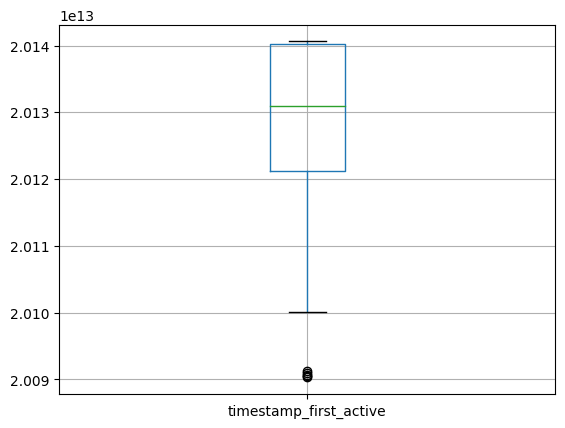

In [56]:
merged_df.boxplot(column=['timestamp_first_active'], return_type='axes')
plt.show()

In [57]:
# Finding the quartile range

col = 'timestamp_first_active'

q1 = np.percentile(merged_df[col].dropna(), 25, method='midpoint')
q3 = np.percentile(merged_df[col].dropna(), 75, method='midpoint')
iqr = q3 - q1

upper = q3 + 1.5 * iqr
lower = q1 - 1.5 * iqr


In [58]:
# Clipping the outliers

merged_df[col] = np.where(merged_df[col] <= lower, lower, merged_df[col])
merged_df[col] = np.where(merged_df[col] >= upper, upper, merged_df[col])


#### age

In [59]:
col = 'age'

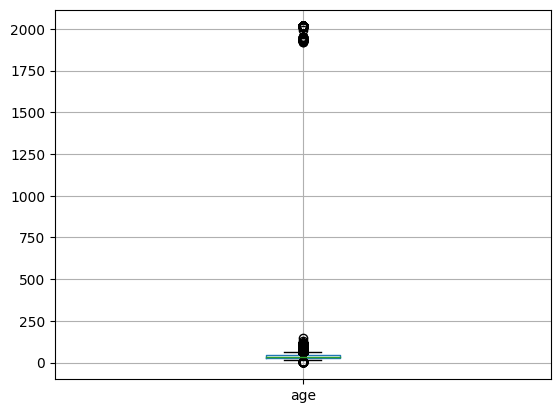

In [60]:
merged_df.boxplot(column=[col], return_type='axes')
plt.show()

In [61]:
# In age we can directly define min and max age
upper = 120.0
lower = 16.0

# Clipping the outliers
merged_df[col] = np.where(merged_df[col] <= lower, lower, merged_df[col])
merged_df[col] = np.where(merged_df[col] >= upper, upper, merged_df[col])


In [62]:
merged_df['age'].min(), merged_df['age'].max()

(16.0, 120.0)

#### signup_flow

In [63]:
col = 'signup_flow'

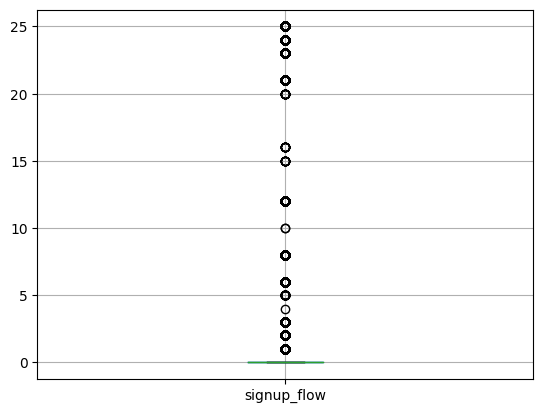

In [64]:
merged_df.boxplot(column=[col], return_type='axes')
plt.show()

In [65]:
merged_df[col].min(), merged_df[col].max()

(0, 25)

In [66]:
merged_df[col].describe()

count    213451.000000
mean          3.267387
std           7.637707
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          25.000000
Name: signup_flow, dtype: float64

In [67]:
q1 = np.percentile(merged_df[col].dropna(), 25, method='midpoint')
q3 = np.percentile(merged_df[col].dropna(), 75, method='midpoint')
iqr = q3 - q1

upper = q3 + 1.5 * iqr
lower = q1 - 1.5 * iqr

print(lower, upper)

0.0 0.0


In [68]:
# As we see almost all the values are 0.0, then removing or capping outliers might lead to losing information, 

#### secs_elapsed

In [69]:
col = 'secs_elapsed'

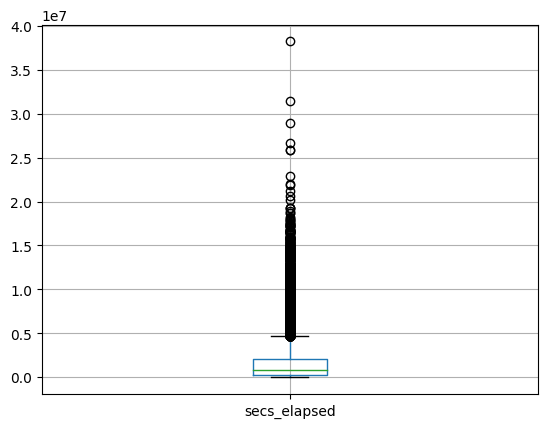

In [70]:
merged_df.boxplot(column=[col], return_type='axes')
plt.show()

In [71]:
q1 = np.percentile(merged_df[col].dropna(), 25, method='midpoint')
q3 = np.percentile(merged_df[col].dropna(), 75, method='midpoint')
iqr = q3 - q1

upper = q3 + 1.5 * iqr
lower = q1 - 1.5 * iqr

print(lower, upper)

-2422930.0 4723338.0


#### population_in_thousands

In [72]:
col = 'population_in_thousands'

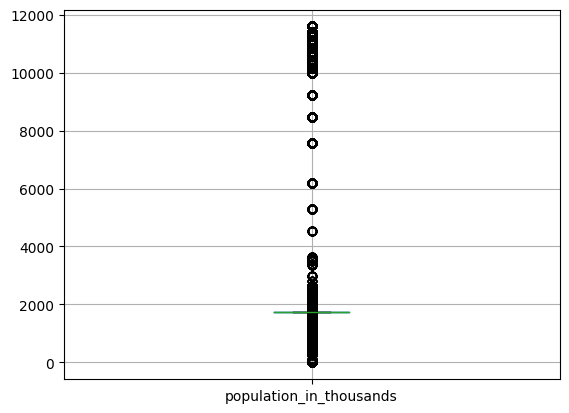

In [73]:
merged_df.boxplot(column=[col], return_type='axes')
plt.show()

In [74]:
q1 = np.percentile(merged_df[col].dropna(), 25, method='midpoint')
q3 = np.percentile(merged_df[col].dropna(), 75, method='midpoint')
iqr = q3 - q1

upper = q3 + 1.5 * iqr
lower = q1 - 1.5 * iqr

print(lower, upper)

1743.1333333333334 1743.1333333333334


In [75]:
len(merged_df[merged_df[col] > upper])

45993

In [76]:
len(merged_df[merged_df[col] < lower])

4128

#### We will not be removing outlier for other columns that might lose information

### Missing Data Handling

In [77]:
merged_df.shape

(213451, 26)

In [78]:
merged_df.isna().sum()

id                                    0
timestamp_first_active                0
gender                                0
age                               87990
signup_method                         0
signup_flow                           0
language                              0
affiliate_channel                     0
affiliate_provider                    0
first_affiliate_tracked            6065
signup_app                            0
first_device_type                     0
first_browser                         0
country_destination                   0
first_booking_year               124543
first_booking_month              124543
account_created_year                  0
account_created_month                 0
lat_destination                  134637
lng_destination                  134637
distance_km                      134637
destination_km2                  134637
destination_language             134637
language_levenshtein_distance    134637
secs_elapsed                     139636


In [187]:
# Handling missing data for numerical columns using meadin method

numerical_imp = SimpleImputer(strategy='median')
numerical_imp_df = numerical_imp.fit_transform(merged_df[numerical_cols])
for index, col in enumerate(numerical_cols):
    merged_df[col] = numerical_imp_df[:, index]
    
joblib.dump(numerical_imp, os.path.join(data_dir, "numerical_imp.joblib"))

['./numerical_imp.joblib']

In [188]:
# Handling categorical column missing values

categorical_imp = SimpleImputer(strategy='most_frequent')
categorical_imp_df = categorical_imp.fit_transform(merged_df[categorical_cols])
for index, col in enumerate(categorical_cols):
    merged_df[col] = categorical_imp_df[:, index]

joblib.dump(categorical_imp, os.path.join(data_dir, "categorical_imp.joblib"))

['./categorical_imp.joblib']

In [81]:
merged_df.isna().sum()

id                               0
timestamp_first_active           0
gender                           0
age                              0
signup_method                    0
signup_flow                      0
language                         0
affiliate_channel                0
affiliate_provider               0
first_affiliate_tracked          0
signup_app                       0
first_device_type                0
first_browser                    0
country_destination              0
first_booking_year               0
first_booking_month              0
account_created_year             0
account_created_month            0
lat_destination                  0
lng_destination                  0
distance_km                      0
destination_km2                  0
destination_language             0
language_levenshtein_distance    0
secs_elapsed                     0
population_in_thousands          0
dtype: int64

### Handling duplicates

In [82]:
merged_df = merged_df.drop_duplicates(keep='first')

## Feature Engineering

Calculate the correlation/strength-of-association of features in data-set with both categorical and continuous features using: * Pearson's R for continuous-continuous cases * Correlation Ratio for categorical-continuous cases * Cramer's V or Theil's U for categorical-categorical cases

In [90]:
y = merged_df['country_destination']
X = merged_df.drop('country_destination', axis=1)

In [95]:
X.columns

Index(['id', 'timestamp_first_active', 'gender', 'age', 'signup_method',
       'signup_flow', 'language', 'affiliate_channel', 'affiliate_provider',
       'first_affiliate_tracked', 'signup_app', 'first_device_type',
       'first_browser', 'first_booking_year', 'first_booking_month',
       'account_created_year', 'account_created_month', 'lat_destination',
       'lng_destination', 'distance_km', 'destination_km2',
       'destination_language ', 'language_levenshtein_distance',
       'secs_elapsed', 'population_in_thousands'],
      dtype='object')

In [122]:
class2id = dict()
id2class = dict()

for index, country in enumerate(y.unique()):
    class2id[country] = index
    id2class[index] = country

In [124]:
class_weights_dict = dict()
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y), y=y)

for cls, index in class2id.items():
    class_weights_dict[index] = class_weights[index]


In [96]:
# We can remove columns like lat_destination, lng_destination, destination_km2

X = X.drop(['lat_destination', 'lng_destination', 'destination_km2'], axis = 1)

/Users/deveshparmar/python_venvs/genral_3_10/lib/python3.10/site-packages/dython/nominal.py:176: RuntimeWarning: Unable to calculate Cramer's V using bias correction. Consider using bias_correction=False (or cramers_v_bias_correction=False if calling from associations)
  warnings.warn(
/Users/deveshparmar/python_venvs/genral_3_10/lib/python3.10/site-packages/dython/nominal.py:176: RuntimeWarning: Unable to calculate Cramer's V using bias correction. Consider using bias_correction=False (or cramers_v_bias_correction=False if calling from associations)
  warnings.warn(
/Users/deveshparmar/python_venvs/genral_3_10/lib/python3.10/site-packages/dython/nominal.py:176: RuntimeWarning: Unable to calculate Cramer's V using bias correction. Consider using bias_correction=False (or cramers_v_bias_correction=False if calling from associations)
  warnings.warn(
/Users/deveshparmar/python_venvs/genral_3_10/lib/python3.10/site-packages/dython/nominal.py:176: RuntimeWarning: Unable to calculate Cramer

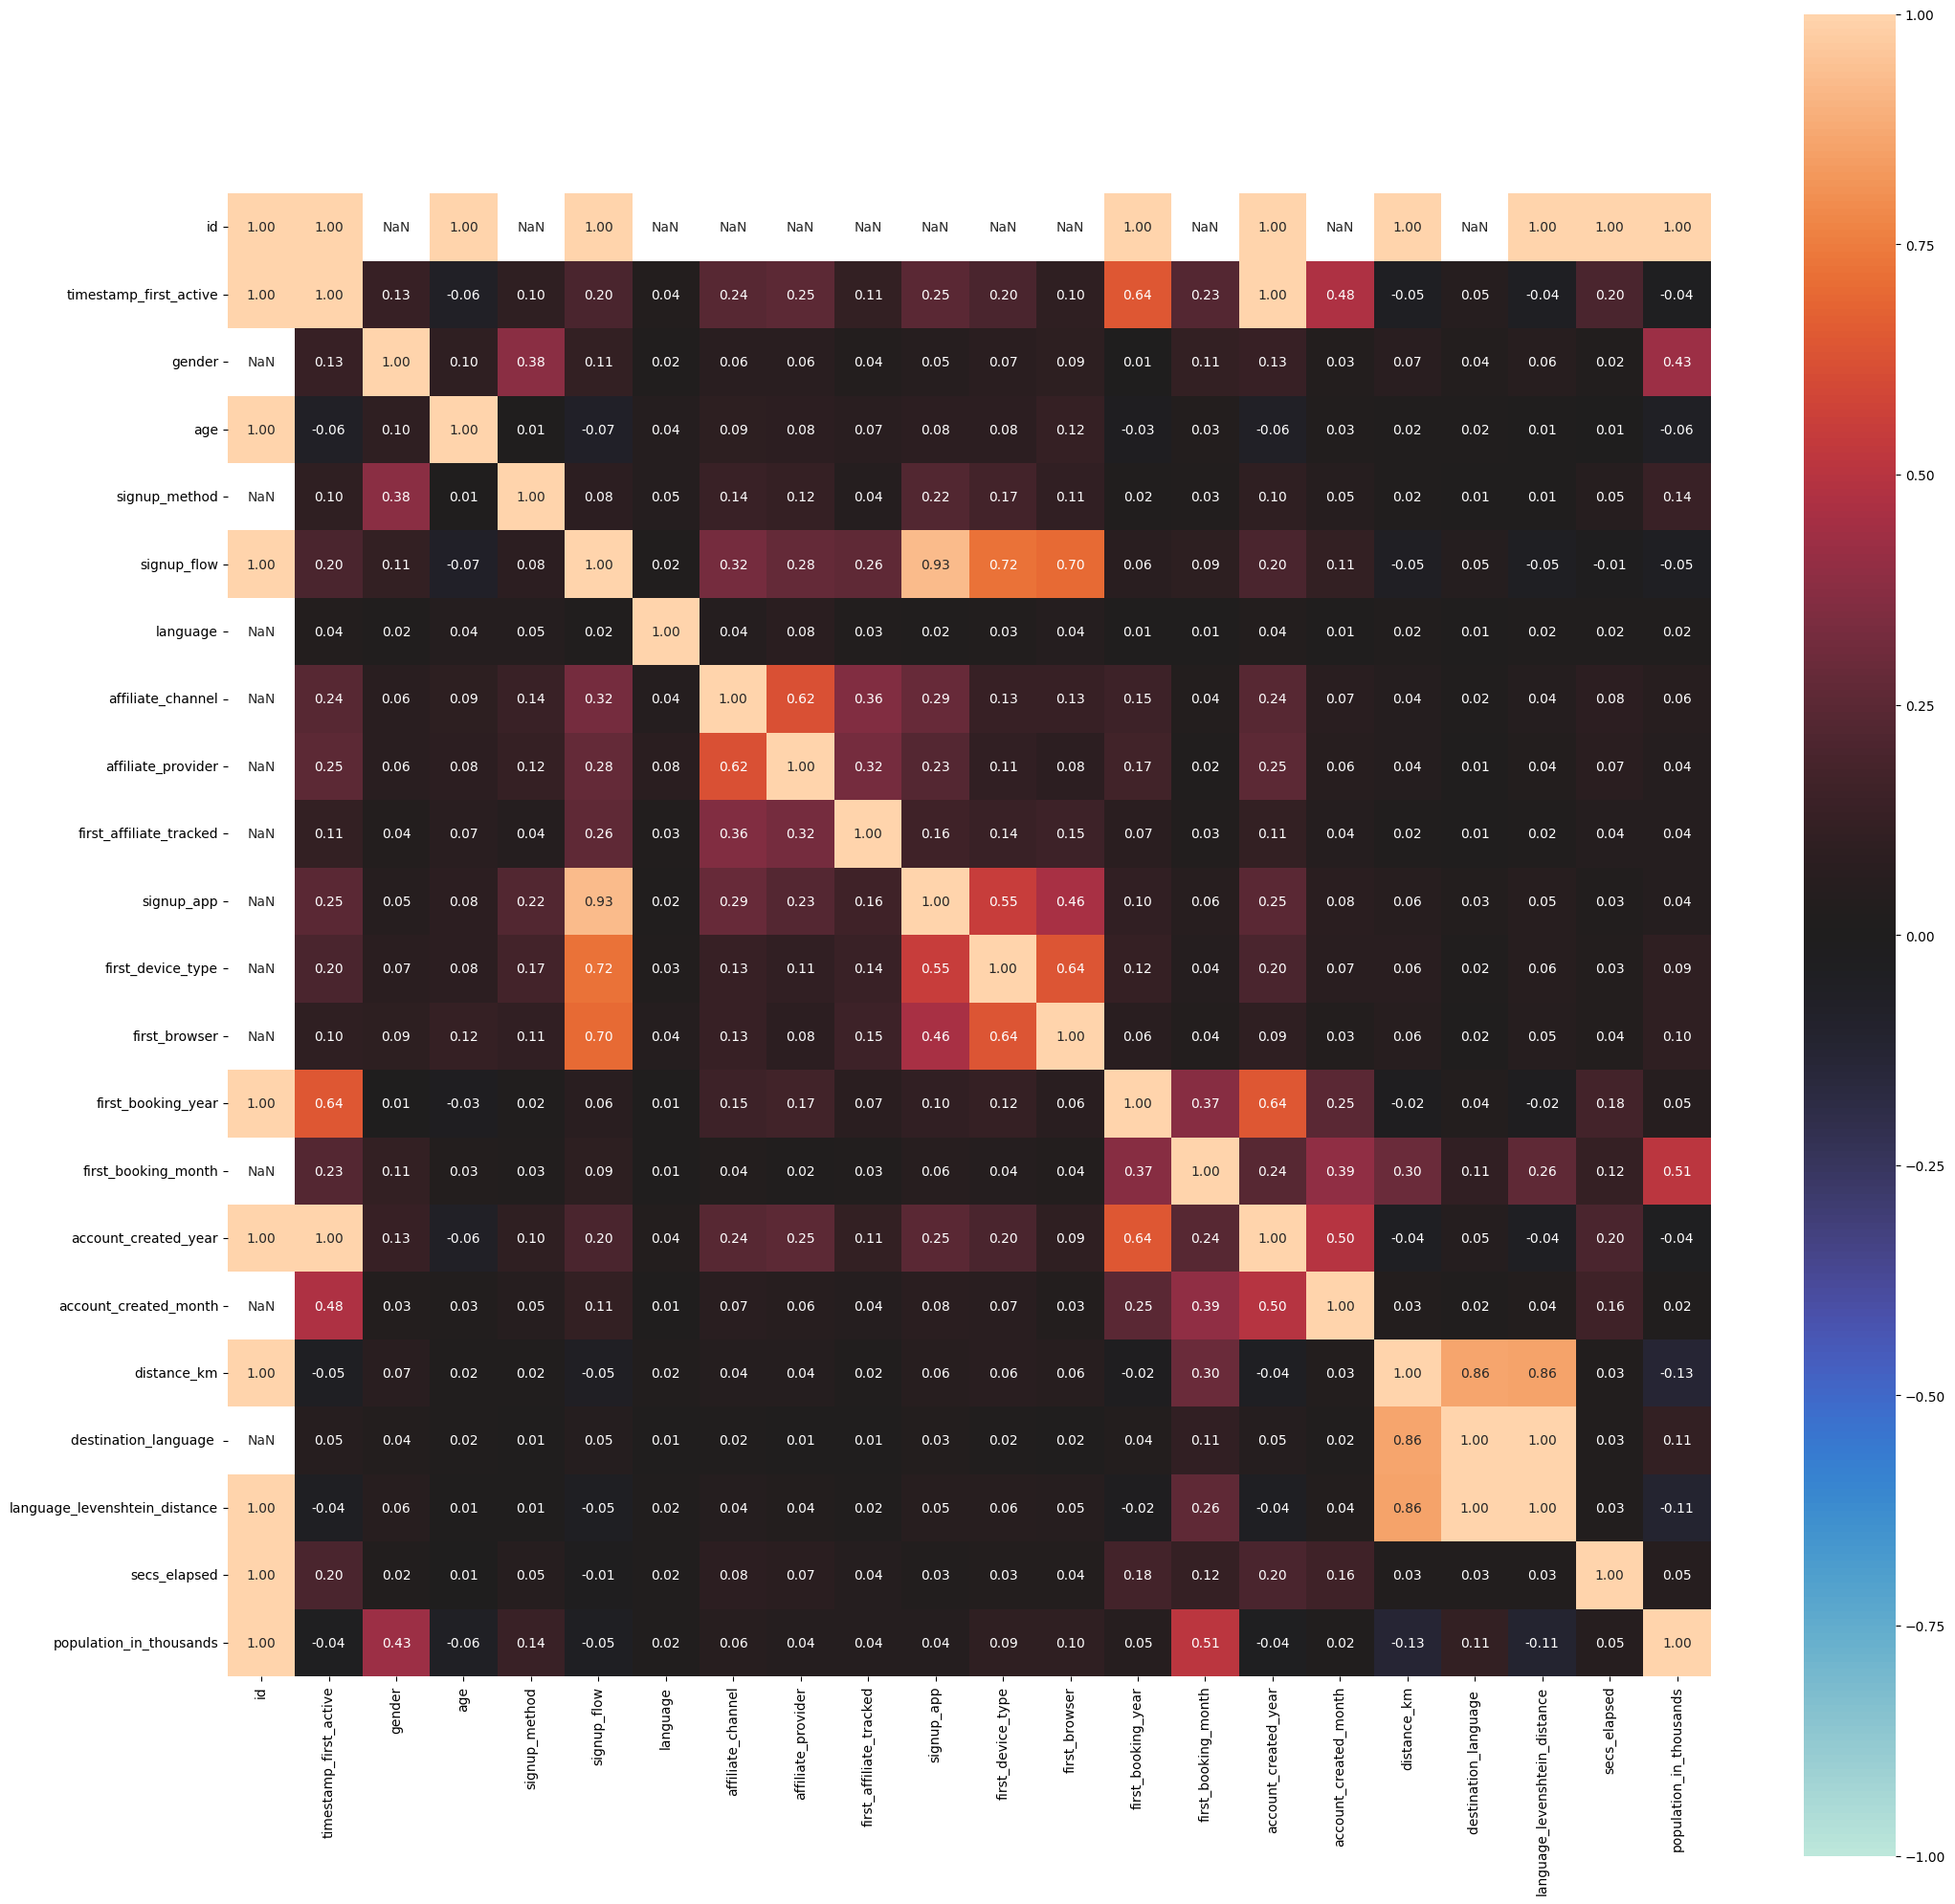

In [97]:
# Finding correlation
complete_correlation = associations(X, filename= 'complete_correlation.png', figsize=(25,25))

In [98]:
complete_correlation['corr']

,id,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,...,first_browser,first_booking_year,first_booking_month,account_created_year,account_created_month,distance_km,destination_language,language_levenshtein_distance,secs_elapsed,population_in_thousands
id,1.0,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
timestamp_first_active,1.0,1.000000,0.129401,-0.064439,0.096268,0.196704,0.036621,0.238206,0.253515,0.111474,...,0.095491,0.644774,0.229940,0.998825,0.475204,-0.045358,0.047440,-0.042765,0.196659,-0.037303
gender,0.0,0.129401,1.000000,0.097836,0.378078,0.109484,0.023407,0.064692,0.064095,0.036603,...,0.088954,0.006696,0.111151,0.128113,0.033792,0.068324,0.036556,0.058214,0.023814,0.425451
age,1.0,-0.064439,0.097836,1.000000,0.010821,-0.071347,0.044768,0.088342,0.083019,0.068903,...,0.119542,-0.029575,0.034044,-0.063624,0.029954,0.019698,0.017694,0.012516,0.005178,-0.055398
signup_method,0.0,0.096268,0.378078,0.010821,1.000000,0.080530,0.045049,0.139304,0.121336,0.039886,...,0.106900,0.023409,0.027313,0.095477,0.053342,0.017362,0.011840,0.014489,0.049893,0.138351
signup_flow,1.0,0.196704,0.109484,-0.071347,0.080530,1.000000,0.021363,0.320708,0.275708,0.262832,...,0.699610,0.063640,0.092237,0.195338,0.111190,-0.051076,0.046422,-0.046067,-0.011724,-0.045753
language,0.0,0.036621,0.023407,0.044768,0.045049,0.021363,1.000000,0.043426,0.076373,0.029342,...,0.041924,0.014537,0.010783,0.036009,0.008830,0.024525,0.014935,0.023245,0.016456,0.021352
affiliate_channel,0.0,0.238206,0.064692,0.088342,0.139304,0.320708,0.043426,1.000000,0.621278,0.358265,...,0.126174,0.154811,0.036044,0.235711,0.066073,0.044315,0.017279,0.040753,0.084262,0.061934
affiliate_provider,0.0,0.253515,0.064095,0.083019,0.121336,0.275708,0.076373,0.621278,1.000000,0.323842,...,0.079140,0.167716,0.021780,0.250534,0.056225,0.040839,0.014180,0.038072,0.070448,0.043928
first_affiliate_tracked,0.0,0.111474,0.036603,0.068903,0.039886,0.262832,0.029342,0.358265,0.323842,1.000000,...,0.150861,0.074516,0.030943,0.111283,0.039671,0.019440,0.008631,0.017589,0.042946,0.039634


In [106]:
columns = X.columns.to_list()

In [107]:
exluded_columns = ['id', 'signup_app', 'destination_language', 'language_levenshtein_distance']

In [108]:
final_columns = set(columns) - set(exluded_columns)

In [110]:
final_columns = list(final_columns)

In [111]:
final_columns

['distance_km',
 'gender',
 'signup_flow',
 'account_created_year',
 'destination_language ',
 'affiliate_provider',
 'first_device_type',
 'timestamp_first_active',
 'language',
 'signup_method',
 'first_affiliate_tracked',
 'account_created_month',
 'population_in_thousands',
 'first_browser',
 'secs_elapsed',
 'first_booking_month',
 'affiliate_channel',
 'age',
 'first_booking_year']

In [112]:
X = X[final_columns]

In [113]:
X.head()

,distance_km,gender,signup_flow,account_created_year,destination_language,affiliate_provider,first_device_type,timestamp_first_active,language,signup_method,first_affiliate_tracked,account_created_month,population_in_thousands,first_browser,secs_elapsed,first_booking_month,affiliate_channel,age,first_booking_year
0,0.0,-unknown-,0.0,2010.0,eng,direct,Mac Desktop,2.009260e+13,en,facebook,untracked,June,1743.133333,Chrome,872862.0,June,direct,34.0,2013.0
1,0.0,MALE,0.0,2011.0,eng,google,Mac Desktop,2.009260e+13,en,facebook,untracked,May,1743.133333,Chrome,872862.0,June,seo,38.0,2013.0
2,0.0,FEMALE,3.0,2010.0,eng,direct,Windows Desktop,2.009260e+13,en,basic,untracked,September,11264.000000,IE,872862.0,August,direct,56.0,2010.0
3,0.0,FEMALE,0.0,2011.0,eng,direct,Mac Desktop,2.009260e+13,en,facebook,untracked,December,1743.133333,Firefox,872862.0,September,direct,42.0,2012.0
4,0.0,-unknown-,0.0,2010.0,eng,direct,Mac Desktop,2.009260e+13,en,basic,untracked,September,1743.133333,Chrome,872862.0,February,direct,41.0,2010.0


## Scaling and encoding

In [116]:
numerical_cols = list(X.select_dtypes(include=['number']))
categorical_cols = list(X.select_dtypes(include=['object', 'category']))

In [117]:
encoder = OneHotEncoder()
scaler = StandardScaler()

transformer = ColumnTransformer([('cat_cols', encoder, categorical_cols),
                                 ('num_cols', scaler, numerical_cols)])

In [118]:
transformer.fit(X)

ColumnTransformer(transformers=[('cat_cols', OneHotEncoder(),
                                 ['gender', 'destination_language ',
                                  'affiliate_provider', 'first_device_type',
                                  'language', 'signup_method',
                                  'first_affiliate_tracked',
                                  'account_created_month', 'first_browser',
                                  'first_booking_month', 'affiliate_channel']),
                                ('num_cols', StandardScaler(),
                                 ['distance_km', 'signup_flow',
                                  'account_created_year',
                                  'timestamp_first_active',
                                  'population_in_thousands', 'secs_elapsed',
                                  'age', 'first_booking_year'])])

In [120]:
joblib.dump(transformer, os.path.join(data_dir, "transformer.joblib"))


['./transformer.joblib']

In [121]:
X = transformer.transform(X)

In [125]:
y = y.replace(class2id)

## Training

In [126]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [127]:
X.shape

(213451, 165)

In [130]:
svc_classifier = SVC(gamma='auto', class_weight=class_weights_dict)

In [131]:
svc_model = Pipeline([("classifier", svc_classifier)])

In [132]:
svc_model.fit(X_train, y_train)

Pipeline(steps=[('classifier',
                 SVC(class_weight={0: 33.00108225108225, 1: 12.456290849673202,
                                   2: 16.76492302858938, 3: 7.909107751593301,
                                   4: 3.541227022363793, 5: 7.653865461847389,
                                   6: 6.274279835390947, 7: 0.1428228269218931,
                                   8: 23.343285214348207, 9: 81.97043010752688,
                                   10: 0.28516710486939423,
                                   11: 1.7621937124364309},
                     gamma='auto'))])

In [133]:
joblib.dump(svc_model, os.path.join(data_dir, "svc_model.joblib"))

['./svc_model.joblib']

## Evaluation

In [134]:
svc_model.score(X_test, y_test)

0.9672530509943548

In [135]:
y_pred = svc_model.predict(X_test)

In [139]:
print(classification_report(y_test, y_pred, target_names=list(class2id.keys())))

              precision    recall  f1-score   support

         NDF       0.99      1.00      1.00     24909
          US       0.94      0.95      0.95     12475
       other       0.72      0.62      0.67      2019
          FR       1.00      1.00      1.00      1005
          CA       1.00      1.00      1.00       286
          GB       1.00      1.00      1.00       465
          ES       1.00      1.00      1.00       450
          IT       1.00      1.00      1.00       567
          PT       1.00      1.00      1.00        43
          NL       1.00      1.00      1.00       152
          DE       1.00      1.00      1.00       212
          AU       1.00      1.00      1.00       108

    accuracy                           0.97     42691
   macro avg       0.97      0.96      0.97     42691
weighted avg       0.97      0.97      0.97     42691



## Prediction

In [189]:
# Load all the saved model, imputer and encoder

loaded_numerical_imp = joblib.load(os.path.join(data_dir, "numerical_imp.joblib"))
loaded_categorical_imp = joblib.load(os.path.join(data_dir, "categorical_imp.joblib"))
                                     

In [190]:
loaded_transformer = joblib.load(os.path.join(data_dir, "transformer.joblib"))
loaded_model = joblib.load(os.path.join(data_dir, "svc_model.joblib"))

In [240]:
def classify(data, n_data):
    if n_data == 1:
        df = pd.DataFrame(data, index=[0])
    else:
         df = pd.DataFrame(data)
    numerical_imp_df = loaded_numerical_imp.transform(df[numerical_cols])
    for index, col in enumerate(numerical_cols):
        df[col] = numerical_imp_df[:, index]
    
    categorical_imp_df = loaded_categorical_imp.transform(df[categorical_cols])
    for index, col in enumerate(categorical_cols):
        df[col] = categorical_imp_df[:, index]
    
    x = loaded_transformer.transform(df)
    predictions = loaded_model.predict(x)
    results = []
    for i in range(len(predictions)):
        pred = predictions[i]
        results.append(id2class[pred])
    
    return results

In [241]:
i = 1290
row = merged_df.iloc[i]
true_label = id2class[y[i]]
row = row[final_columns]
print(classify(row.to_dict(), 1), true_label)

['NDF'] NDF
